# Common imports

In [1]:
%matplotlib inline
import os
import sys
import glob
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

# Provided functions
### Image loading and saving

In [2]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    
    #lightdirs = np.delete(lightdirs, [17, 19, 46, 61], axis=0)
    
    return ambimage, imarray, lightdirs

In [3]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

### Plot the height map

In [4]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


def display_output(albedo_image, height_map):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(-30, -40)
    #40, 40
    #40, -40
    #-30, 40
    #-30. -40
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='jet', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

### Plot the surface norms. 

In [5]:
def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0])
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1])
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2])

# Your implementation

In [17]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    
    imarray_shape = imarray.shape
    processed_imarray = np.zeros_like(imarray)
    
    processed_imarray = imarray - ambimage.reshape(imarray_shape[0], imarray_shape[1], 1)
    processed_imarray = np.clip(processed_imarray, 0, None)
    processed_imarray = processed_imarray/processed_imarray.max()
    
    #images to take out for subset analysis: 17, 19, 46, 61
    
#     for i in range(imarray_shape[2]):
#         plt.figure()
#         plt.imshow(imarray[:, :, i])
#         plt.title(i)
        
    #processed_imarray = np.delete(processed_imarray, [17, 19, 46, 61], axis=2)
    #print(processed_imarray.shape)

    return processed_imarray

In [7]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    imarray_shape = imarray.shape
    imarray = imarray.transpose((2, 0, 1))
    imarray = imarray.reshape((imarray_shape[2], imarray_shape[0]*imarray_shape[1]))
    
    g = np.linalg.lstsq(light_dirs, imarray, rcond=None)[0]
    albedo_image = np.linalg.norm(g, axis=0)
    surface_normals = g / albedo_image
    
    albedo_image = albedo_image.reshape(imarray_shape[0], imarray_shape[1])
    surface_normals = surface_normals.reshape(3, imarray_shape[0], imarray_shape[1])
    surface_normals = surface_normals.transpose(1, 2, 0)
    
    return albedo_image, surface_normals

In [8]:
def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    
    X, Y, _ = surface_normals.shape
    fx = surface_normals[:, :, 0]/surface_normals[:, :, 2]
    fy = surface_normals[:, :, 1]/surface_normals[:, :, 2]
    height_map = np.zeros((X, Y))
    
    if integration_method == "column":
        height_map = np.cumsum(fx, axis=1)[:, 0,np.newaxis] + np.cumsum(fy, axis=0)
        
    elif integration_method == "row":
        height_map = np.cumsum(fy, axis=0)[0] + np.cumsum(fx, axis=1)
        
    elif integration_method == "average":
        height_map = (np.cumsum(fx, axis=1)[:, 0,np.newaxis] + np.cumsum(fy, axis=0) /
                        + np.cumsum(fy, axis=0)[0] + np.cumsum(fx, axis=1))/2
        
    elif integration_method == "random":
        paths = 15
        for a in range(paths):
            for i in range(X):
                for j in range(Y):
                    x = 0
                    y = 0
                    fxy = 0
                    while(x <= i and y <= j):
                        if x == i and y == j:
                            break
                        elif x == i:
                            y += 1
                            fxy += fx[x, y]
                        elif y == j:
                            x += 1
                            fxy += fy[x, y]
                        elif np.random.randint(2):
                            x += 1
                            fxy += fy[x, y]
                        else:
                            y += 1
                            fxy += fx[x, y]
                    height_map[i, j] += fxy
        height_map = height_map/paths
        

    return height_map

# Main function

In [18]:
root_path = 'croppedyale/'
subject_name = 'yaleB01'
integration_method = 'column'
save_flag = False

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    60)

processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                   light_dirs)

height_map = get_surface(surface_normals, integration_method)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

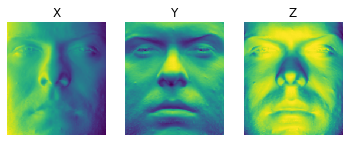

In [10]:
plot_surface_normals(surface_normals)

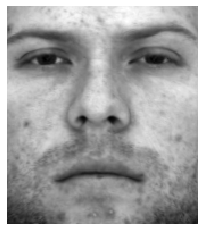

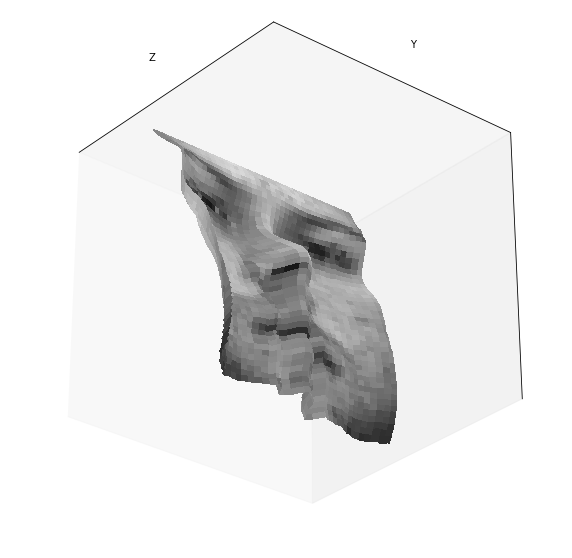

In [11]:
display_output(albedo_image, height_map)

In [12]:
import time

In [13]:
runtime = 0
for i in range(10):
    start_time = time.time()
    height_map = height_map = get_surface(surface_normals, 'row')
    runtime += time.time()-start_time
runtime = runtime/10

print('average time:', runtime)

average time: 0.0006983280181884766


In [14]:
runtime = 0
for i in range(10):
    start_time = time.time()
    height_map = height_map = get_surface(surface_normals, 'column')
    runtime += time.time()-start_time
runtime = runtime/10

print('average time:', runtime)

average time: 0.0005984067916870117


In [15]:
runtime = 0
for i in range(10):
    start_time = time.time()
    height_map = height_map = get_surface(surface_normals, 'average')
    runtime += time.time()-start_time
runtime = runtime/10

print('average time:', runtime)

average time: 0.000997471809387207


In [16]:
# runtime = 0
# for i in range(10):
#     start_time = time.time()
#     height_map = height_map = get_surface(surface_normals, 'random')
#     runtime += time.time()-start_time
# runtime = runtime/10

# print('average time:', runtime)